In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

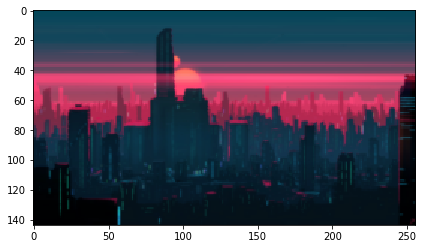

In [3]:
from skimage import io
from skimage.transform import rescale

# read our testing image in
tst_image = io.imread('./test_images/4.jpg')

# downsize the image
tst_image = rescale(tst_image, 0.1, anti_aliasing=True)
io.imshow(tst_image)

In [26]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def results_to_df(x_dat, clusters):
    concatenated = []
    for pixel, cluster in zip(x_dat, clusters):
        pixel = list(pixel)
        pixel.append(cluster)
        concatenated.append(pixel)
    result_df = pd.DataFrame(concatenated)
    result_df.columns = ['r', 'g', 'b', 'cluster']
    return result_df

def cluster_image_colours(input_img, reshape=True, cluster_model=DBSCAN, *model_args, **model_kwargs):
    x_dat = input_img
    # get the number of pixels using the shape of the image
    x_len = input_img.shape[0]
    y_len = input_img.shape[1]
    num_pixels = x_len * y_len

    if reshape:
        # reshape to a 2d array
        x_dat = input_img.reshape(num_pixels, 3)

    # train/predict with input model
    model = cluster_model(*model_args, **model_kwargs).fit(x_dat)
    clusters = model.predict(x_dat)

    # create a df with cluster as a label
    labelled_df = results_to_df(x_dat, clusters)
    cluster_labels = labelled_df['cluster'].unique()
    closest_colours_to_centers, _ = pairwise_distances_argmin_min(model.cluster_centers_, x_dat)

    # get cluster colours + number of instances for each cluster
    c_summaries = {}
    for cluster, closest_index in enumerate(closest_colours_to_centers):
        cluster_instances = labelled_df[labelled_df['cluster'] == cluster]

        c_summaries[cluster] = {
            'colour': x_dat[closest_index],
            'num_instances': cluster_instances.shape[0]
        }

    # label each row with it's cluster's colour
    labelled_df['colour'] = labelled_df['cluster'].apply(
        lambda c: c_summaries[c]['colour']
    ) 

    # shaping back to the original image dimensions
    final_img = labelled_df.iloc[:, -1].values
    final_img = np.array([np.array(pixel) for pixel in final_img])
    
    # reshape to original shape
    if reshape:
        final_img = final_img.reshape(x_len, y_len, 3)

    return final_img, c_summaries

get_colours_from_summary = lambda _cluster_summaries: [
    _cluster_summaries[c]['colour'] for c in _cluster_summaries]

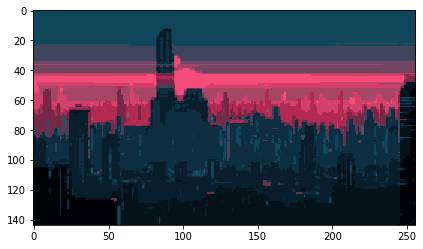

In [27]:
from sklearn.cluster import KMeans, SpectralClustering

clustered_image, img_cluster_summaries = cluster_image_colours(tst_image,
                                                               cluster_model=KMeans,
                                                               n_clusters=12)
cluster_colours = get_colours_from_summary(img_cluster_summaries)
io.imshow(clustered_image)

In [6]:
flatten_img = lambda img: img.reshape(img.shape[0] * img.shape[1], img.shape[2])

def plot_image_colours(image_or_list, flatten=True, cluster_center_list=[]):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # lambda for plotting
    plot_pixel = lambda _pixel, _ax: _ax.scatter(*_pixel[:3], color=tuple(_pixel), alpha=0.1)

    # so we can plot multiple images or just a single image
    if type(image_or_list) == list:
        for _image in image_or_list:
            if flatten:
                _image = flatten_img(_image)
            for pixel in _image:
                plot_pixel(pixel, ax)
    else:
        if flatten:
            image_or_list = flatten_img(image_or_list)
        for pixel in image_or_list:
            plot_pixel(pixel, ax)
    for cluster_center in cluster_center_list:
        ax.scatter(*cluster_center, color='r', marker='x', s=150)

    # label our axes
    ax.set_xlabel('red')
    ax.set_ylabel('green')
    ax.set_zlabel('blue')
    plt.show()

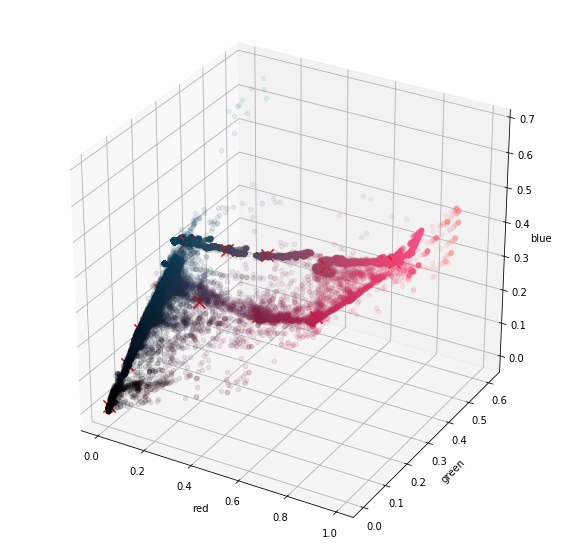

In [8]:
plot_image_colours(tst_image, cluster_center_list=cluster_colours)

# Clustering Video Frames

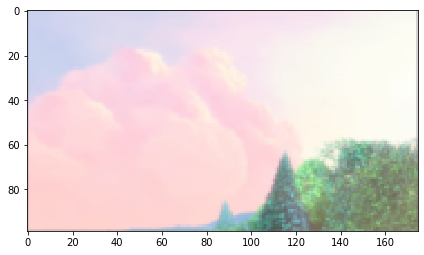

In [41]:
# for casting images to sk image format and rescaling
rescale_image = lambda _image, _amount=0.1: rescale(_image, _amount, anti_aliasing=True)
cast_frame = lambda _image: rescale_image(np.array([np.array(_pixel) for _pixel in _image]))

test_images = [] 
for i in range(1, 5):
    tst_i = io.imread('./test_images/BigBuckBunny/%d.png' % i)
    tst_i = rescale_image(tst_i)
    test_images.append(tst_i)

io.imshow(test_images[0])

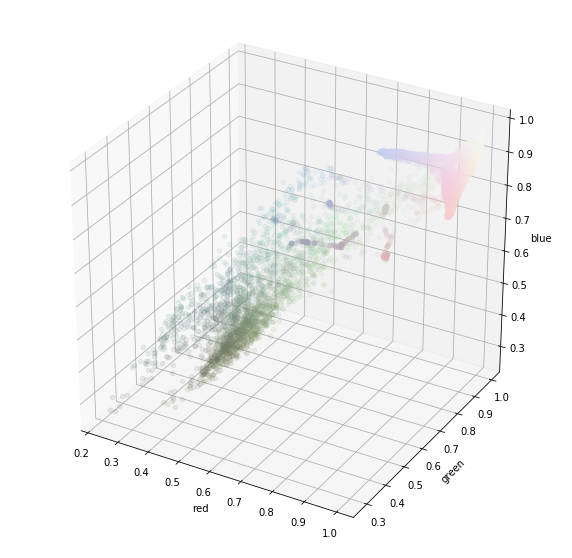

In [42]:
plot_image_colours(test_images[0])

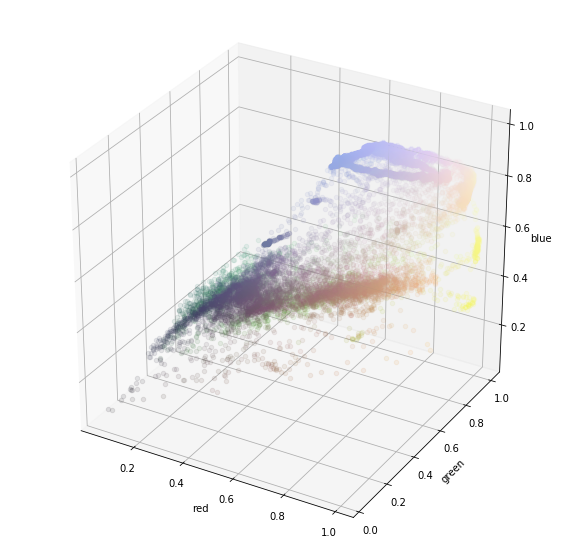

In [43]:
plot_image_colours(test_images[1])

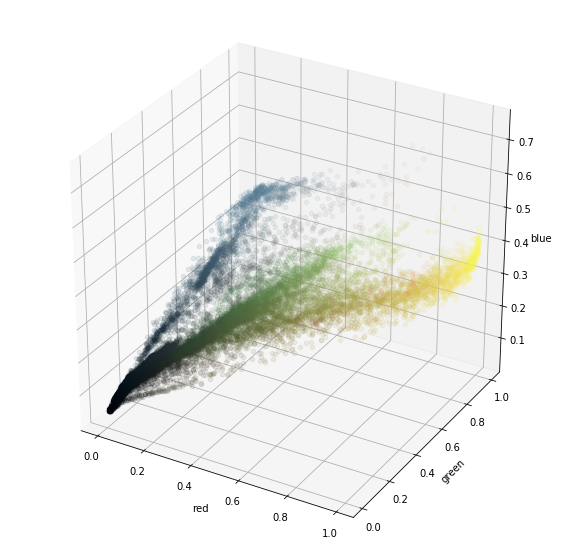

In [44]:
plot_image_colours(test_images[2])

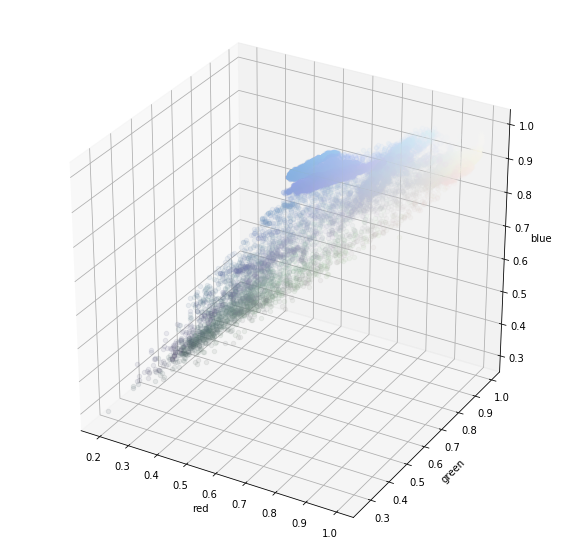

In [45]:
plot_image_colours(test_images[3])

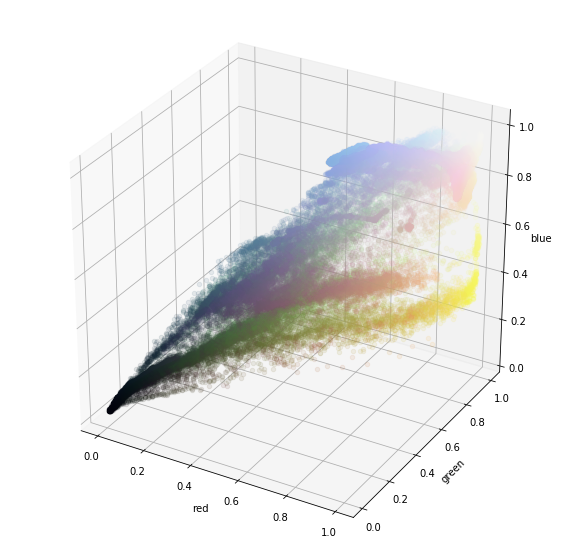

In [46]:
plot_image_colours(test_images)

In [ ]:
import cv2

def get_x_test_frames(vid_name='./test_videos/BigBuckBunny.mp4',
                      num_frames=5000,
                      num_clusters=5):
    # should check it exists

    train_vid = cv2.VideoCapture(vid_name)

    # for storing our clustered data
    x_dat_arr = []
    count = 0

    # read in a frame
    success, image = train_vid.read()
    while success:
        if count >= num_frames:
            break
        image = cast_frame(image)
        image_clustered, colours = cluster_image_colours(image,
                                                         cluster_model=KMeans,
                                                         n_clusters=num_clusters)
        # this allows us to use this data later for clustering frames
        # i.e. an all black frame will only be able to find one cluster
        # we need consistent shape for kmeans
        if len(colours) == num_clusters:
            x_dat_arr.append(np.array(sorted(colours, key=lambda x: x[0])))
        success, image = train_vid.read()
        count += 1
        print('%d/%d' % (count, num_frames), sep='\r')
    return np.array(x_dat_arr)

In [ ]:
# big_buck_5000 =  get_x_test_frames()
# np.save('./test_videos/first_5000_frames.npy', big_buck_5000)

In [9]:
big_buck_5000 = np.load('./test_videos/first_5000_frames.npy', allow_pickle=True)

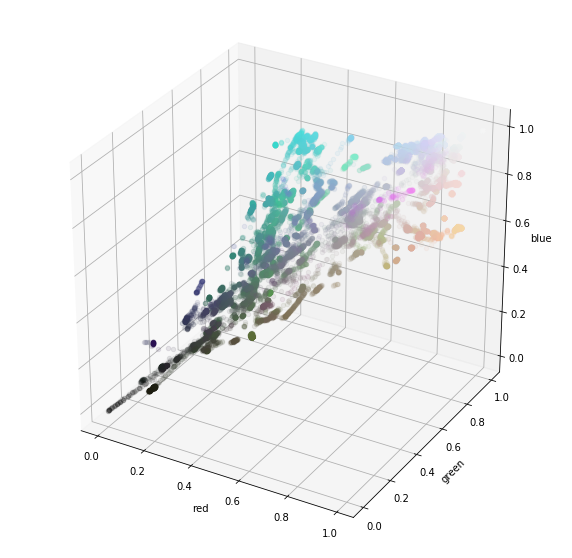

In [40]:
plot_image_colours(big_buck_5000, flatten=False)

In [10]:
# we still have some frames that only found 1 cluster,
# we need to filter these out so we can cluster
big_buck_5000 = big_buck_5000[[len(n) == 5 for n in big_buck_5000]]

# flatten our array, reshape wasn't working because our shape was (4996,)
big_buck_5000_2 = []
for row in big_buck_5000:
    for colour in row:
        big_buck_5000_2.append(colour)
big_buck_5000 = np.array(big_buck_5000_2)
print(big_buck_5000.shape)

(24980, 3)


running model 0
running model 1
running model 2
running model 3
running model 4
running model 5
running model 6
running model 7
running model 8
running model 9
running model 10
running model 11
running model 12
running model 13
running model 14
running model 15
running model 16
running model 17
running model 18
running model 19
running model 20
running model 21
running model 22
running model 23
running model 24
running model 25
running model 26
running model 27
running model 28
running model 29
running model 30
running model 31
running model 32
running model 33
running model 34
running model 35
running model 36
running model 37


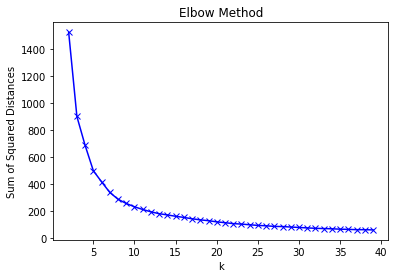

In [11]:
def detect_optimal_clusters(x_data, k_from=2, k_to=18):
    sum_of_sqrd_distances = []
    k_range = range(k_from, k_to)
    for idx, k in enumerate(k_range):
        print('running model %d' % idx)
        km = KMeans(n_clusters=k)
        km = km.fit(x_data)
        sum_of_sqrd_distances.append(km.inertia_)
    plt.plot(k_range, sum_of_sqrd_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method')
    plt.show()

detect_optimal_clusters(big_buck_5000, k_to=40)

In [28]:
frames_colours_clustered, frame_cluster_summaries = cluster_image_colours(big_buck_5000,
                                                                          reshape=False,
                                                                          cluster_model=KMeans,
                                                                          n_clusters=15)
frame_colours = get_colours_from_summary(frame_cluster_summaries)

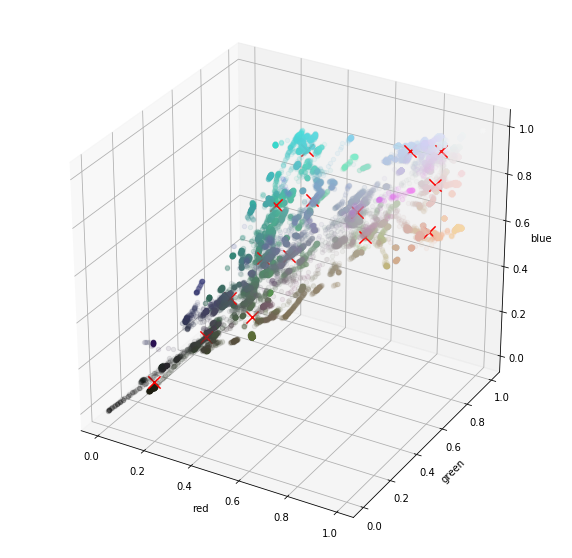

In [47]:
plot_image_colours(big_buck_5000, cluster_center_list=frame_colours, flatten=False)

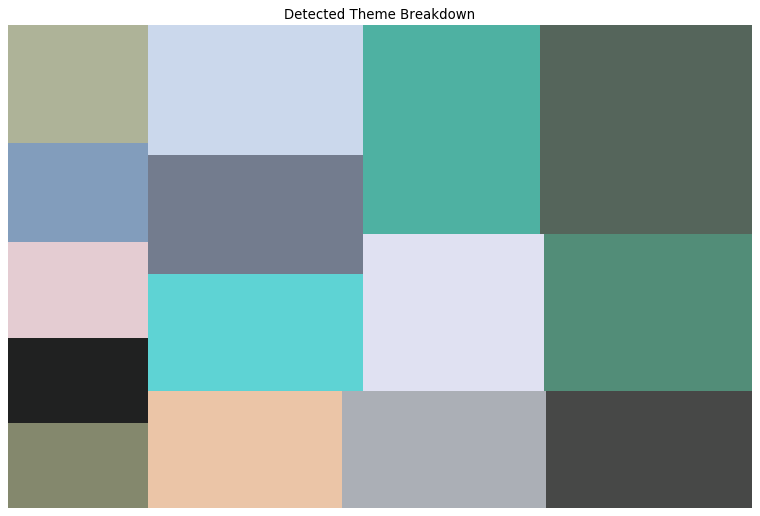

In [30]:
import squarify

def plot_colour_breakdown(cluster_summaries):
    total_instances = sum([cluster_summaries[c]['num_instances'] for c in cluster_summaries])
    colours = [cluster_summaries[c] for c in cluster_summaries]

    # sort the colour sizes
    colour_breakdown = list(sorted(colours,
                                   key=lambda x: x['num_instances']))

    for _colour in colour_breakdown:
        _colour['percent_size'] = _colour['num_instances'] / total_instances

    colours = [c['colour'] for c in colour_breakdown]
    sizes = [c['percent_size'] for c in colour_breakdown]

    plt.figure(figsize=(12, 8), dpi=80)
    squarify.plot(sizes=sizes, color=colours)

    plt.title('Detected Theme Breakdown')
    plt.axis('off')
    plt.show()

plot_colour_breakdown(frame_cluster_summaries)

In [13]:
frames_colours_clustered.shape

(24980, 3)

# Frequent Item Set Detection

# todo
